# RNN / LSTM / GRU

## setup

In [24]:
from datetime import datetime
from torchvision import datasets, transforms
import os
import wandb
import requests
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm

device = 'cuda' if t.cuda.is_available() else 'cpu'

## utils

In [25]:
# download alice in wonderland
path = f'data/alice.txt'
if not os.path.exists(path):
    url = 'https://www.gutenberg.org/cache/epub/11/pg11.txt'
    book = requests.get(url).content
    book = book.decode('ascii', 'ignore')
    with open(path, 'w') as file:
        file.write(book)

with open(path, 'r') as file:
    book = file.read()
assert (start := book.find('\nDown the Rabbit-Hole')) != -1
assert (end := book.find('THE END')) != -1
book = book[start: end]

In [26]:
vocab = set(book)
d_vocab = len(vocab)
d_hidden = 100
d_batch = 10000
atoi = {a: i for i, a in enumerate(sorted(vocab))}
itoa = {i: a for a, i in atoi.items()}

In [27]:
def to_dataloader(text, seq_len=25, batch_size=d_batch):
    # use a chunk with both x and y overlapping to share the same memory
    # also use seq_len // 2 to make more training data
    chunks = [text[i:i+seq_len+1] for i in range(0, len(text)-seq_len-1, seq_len // 2)]
    chunks = t.tensor([[atoi[a] for a in s] for s in chunks])
    x = chunks[:, :-1]
    y = chunks[:, 1:]
    assert x.untyped_storage().data_ptr() == y.untyped_storage().data_ptr()
    dataset = TensorDataset(x, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataloader = to_dataloader(book, 50)

In [28]:
def train(model, dataloader, epochs=2001, opt=None, lr=3e-4, filename='', wnb=True):
    model.train()
    model = model.to(device)
    if opt is None: opt = t.optim.AdamW(model.parameters(), lr=lr)
    if wnb: wandb.init(project=filename)
    for epoch in tqdm(range(epochs)):
        for xs, ys in dataloader:
            with t.autocast(device_type=device, dtype=t.bfloat16):
                out = model(xs.to(device))
                loss = F.cross_entropy(out.permute(0, 2, 1), ys.to(device))
            opt.zero_grad()
            loss.backward()
            opt.step()
        if wnb:
            wandb.log({'loss': loss.item()})
        if wnb and epoch % 100 == 0:
            wandb.log({'sample_html': wandb.Html(f'<p>{model.sample(d_sample=200)}</p>')})
        if epoch % 50 == 0:
            print(f'loss={loss.item():.4f}')
        if epoch % 1000 == 0:
            print(model.sample())
        if epoch % 1000 == 0:
            t.save(model.state_dict(), f'weights/{filename}_{datetime.now().strftime("%Y-%m-%d_%Hh%M")}.pt')
    if wnb: wandb.finish()

## Recurrent Neural Networks (RNN)

### model

In [29]:
# class RNN(nn.Module):
#     def __init__(self, d_in=10, d_hidden=20, d_out=30):
#         super().__init__()
#         self.d_hidden = d_hidden
#         self.embed = nn.Embedding(d_in, d_hidden)
#         self.hidden = nn.Linear(d_hidden, d_hidden)
#         self.unembed = nn.Linear(d_hidden, d_out)

#     def forward(self, xs, memory=None, return_memory=False):
#         # xs: (batch, d_context, d_vocab)
#         batch, d_context, _ = xs.shape
#         outs = []
#         if memory is None: memory = t.zeros(batch, self.hidden.in_features, device=xs.device)
#         for i in range(d_context):
#             x = xs[:, i]
#             memory = F.tanh(self.embed(x) + self.hidden(memory))
#             outs.append(self.unembed(memory))
#         if return_memory:
#             return t.stack(outs, dim=1), memory
#         return t.stack(outs, dim=1)

#     @t.no_grad()
#     def sample(self, seed='A', d_sample=100):
#         text = seed
#         x = F.one_hot(t.tensor([atoi[seed]]), num_classes=d_vocab).float().to(device)
#         h_prev = t.zeros(1, self.d_hidden, device=x.device)
#         while len(text) < d_sample:
#             h_prev = F.tanh(self.embed(x) + self.hidden(h_prev))
#             out = self.unembed(h_prev)
#             probs = out[0].softmax(-1)
#             next_sample = t.multinomial(probs, num_samples=1)
#             text += itoa[next_sample.item()]
#             x = F.one_hot(next_sample, num_classes=d_vocab).float().to(device)
#         return text

# rnn = RNN(d_vocab, d_hidden, d_vocab).to(device)
# rnn.sample()

In [30]:
class RNN(nn.Module):
    def __init__(self, d_in, d_hidden):
        super().__init__()
        self.d_hidden = d_hidden
        self.i2h = nn.Linear(d_in, d_hidden)
        self.h2h = nn.Linear(d_hidden, d_hidden)

    def forward(self, xs, memory=None, return_memory=False):
        # xs: (batch, d_context, d_in)
        batch, d_context, _ = xs.shape
        outs = []
        if memory is None: memory = t.zeros(batch, self.d_hidden, device=xs.device)
        for i in range(d_context):
            x = xs[:, i]
            memory = F.tanh(self.i2h(x) + self.h2h(memory))
            outs.append(memory)
        return t.stack(outs, dim=1)

class AliceRNN(nn.Module):
    def __init__(self, d_vocab, d_hidden):
        super().__init__()
        self.d_hidden = d_hidden
        self.embed = nn.Embedding(d_vocab, d_hidden)
        self.rnn = RNN(d_hidden, d_hidden)
        self.unembed = nn.Linear(d_hidden, d_vocab)
        self.unembed.weight = self.embed.weight

    def forward(self, xs):
        xs = self.embed(xs)
        out = self.rnn(xs)
        return self.unembed(out)

    @t.no_grad()
    def sample(self, text='A', d_sample=100):
        x = t.tensor([[atoi[c] for c in text]]).to(device)
        h_prev = t.zeros(1, self.d_hidden, device=x.device)
        while len(text) < d_sample:
            x = self.embed(x)
            h_prev = self.rnn(x, h_prev)[:, -1]
            out = self.unembed(h_prev)
            probs = out.softmax(-1)
            next_sample = t.multinomial(probs, num_samples=1)
            text += itoa[next_sample[0].item()]
            x = next_sample
        return text

rnn = AliceRNN(d_vocab, d_hidden).to(device)
rnn.sample()

'AEUqpV] ]?.JrWHYc,]SfRe:_OjD\nZqpQDHDUgpVzHYi-vF\nZ[QDHD_RUqpQDHDswcbzN,lBSjLbzNi-zN,lBSjLw\nZc,]SEUUUU'

### train

In [31]:
# train(rnn, dataloader, filename='rnn')

In [32]:
# print(rnn.sample(d_sample=2000))

## Long Short-Term Memory (LSTM)

### model

In [33]:
class LSTMCell(nn.Module):
    def __init__(self, d_in, d_hidden):
        super().__init__()
        self.W_f = nn.Linear(d_in + d_hidden, d_hidden)  # forget gate
        self.W_i = nn.Linear(d_in + d_hidden, d_hidden)  # input gate
        self.W_c = nn.Linear(d_in + d_hidden, d_hidden)  # cell state update
        self.W_o = nn.Linear(d_in + d_hidden, d_hidden)  # output gate

    def forward(self, x, h_prev, c_prev):
        x = t.cat((x, h_prev), dim=1)
        # handle long-term memory `C`
        f_gate = t.sigmoid(self.W_f(x))
        i_gate = t.sigmoid(self.W_i(x))
        c_update = t.tanh(self.W_c(x))
        c_prev = f_gate * c_prev + i_gate * c_update
        # handle short-term memory `h`
        o_gate = t.sigmoid(self.W_o(x))
        h_prev = o_gate * t.tanh(c_prev)
        return h_prev, c_prev

class LSTM(nn.Module):
    def __init__(self, d_in, d_hidden):
        super().__init__()
        self.d_hidden = d_hidden
        self.lstm_cell = LSTMCell(d_in, d_hidden)

    def forward(self, xs, h_prev=None, c_prev=None):
        # xs: (batch, d_context, d_in)
        batch, d_context, _ = xs.shape
        hs, cs = [], []
        if h_prev is None: h_prev = t.zeros(batch, self.d_hidden, device=xs.device)
        if c_prev is None: c_prev = t.zeros(batch, self.d_hidden, device=xs.device)
        for i in range(d_context):
            x = xs[:, i]
            h_prev, c_prev = self.lstm_cell(x, h_prev, c_prev)
            hs.append(h_prev)
            cs.append(c_prev)
        return t.stack(hs, dim=1), t.stack(cs, dim=1)

class AliceLSTM(nn.Module):
    def __init__(self, d_vocab, d_hidden):
        super().__init__()
        self.d_hidden = d_hidden
        self.embed = nn.Embedding(d_vocab, d_hidden)
        self.lstm = LSTM(d_hidden, d_hidden)
        self.unembed = nn.Linear(d_hidden, d_vocab)
        self.unembed.weight = self.embed.weight

    def forward(self, xs):
        xs = self.embed(xs)
        out, _ = self.lstm(xs)
        return self.unembed(out)

    @t.no_grad()
    def sample(self, text='A', d_sample=100):
        x = t.tensor([[atoi[c] for c in text]]).to(device)
        h_prev = t.zeros(1, self.d_hidden, device=x.device)
        c_prev = t.zeros(1, self.d_hidden, device=x.device)
        while len(text) < d_sample:
            x = self.embed(x)
            h_prev, c_prev = self.lstm(x, h_prev, c_prev)
            h_prev, c_prev = h_prev[:, -1], c_prev[:, -1]
            out = self.unembed(h_prev)
            probs = out.softmax(-1)
            next_sample = t.multinomial(probs, num_samples=1)
            text += itoa[next_sample[0].item()]
            x = next_sample
        return text

lstm = AliceLSTM(d_vocab, d_hidden).to(device)
lstm.sample()

'ABW*SISYV;gHVVBSBw.FRxrqizoVilq\nJ GGYAj\njU\nfyO(dq(qq\n.-?Q\nUcq\n\nT-xquFPFMrJYWOd.)R:UUoad-irovUlEf(qZH'

### train

In [34]:
# train(lstm, dataloader, filename='lstm')

In [35]:
# print(lstm.sample(d_sample=2000))

## Gated Recurrent Unit (GRU)

### model

In [36]:
class GRUCell(nn.Module):
    def __init__(self, d_in, d_hidden):
        super().__init__()
        self.W_r = nn.Linear(d_in + d_hidden, d_hidden)  # reset gate
        self.W_z = nn.Linear(d_in + d_hidden, d_hidden)  # update gate
        self.W_h = nn.Linear(d_in + d_hidden, d_hidden)  # hidden state update

    def forward(self, x, h_prev):
        cat = t.cat((x, h_prev), dim=1)
        r_gate = t.sigmoid(self.W_r(cat))
        z_gate = t.sigmoid(self.W_z(cat))
        h_candidate = t.tanh(self.W_h(t.cat((x, r_gate * h_prev), dim=1)))
        h_prev = (1 - z_gate) * h_prev + z_gate * h_candidate
        return h_prev

class GRU(nn.Module):
    def __init__(self, d_in, d_hidden):
        super().__init__()
        self.d_hidden = d_hidden
        self.gru_cell = GRUCell(d_in, d_hidden)

    def forward(self, xs, h_prev=None):
        # xs: (batch, d_context, d_in)
        batch, d_context, _ = xs.shape
        outs = []
        if h_prev is None: h_prev = t.zeros(batch, self.d_hidden, device=xs.device)
        for i in range(d_context):
            x = xs[:, i]
            h_prev = self.gru_cell(x, h_prev)
            outs.append(h_prev)
        return t.stack(outs, dim=1)

class AliceGRU(nn.Module):
    def __init__(self, d_vocab, d_hidden):
        super().__init__()
        self.d_hidden = d_hidden
        self.embed = nn.Embedding(d_vocab, d_hidden)
        self.gru = GRU(d_hidden, d_hidden)
        self.unembed = nn.Linear(d_hidden, d_vocab)
        self.unembed.weight = self.embed.weight

    def forward(self, xs):
        xs = self.embed(xs)
        out = self.gru(xs)
        return self.unembed(out)

    @t.no_grad()
    def sample(self, text='A', d_sample=100):
        x = t.tensor([[atoi[c] for c in text]], device=device)
        h_prev = t.zeros(1, self.d_hidden, device=device)
        while len(text) < d_sample:
            x = self.embed(x)
            h_prev = self.gru(x, h_prev)[:, -1]
            out = self.unembed(h_prev)
            probs = out.softmax(-1)
            next_sample = t.multinomial(probs, num_samples=1)
            text += itoa[next_sample[0].item()]
            x = next_sample
        return text

gru = AliceGRU(d_vocab, d_hidden).to(device)
gru.sample()

'A_DtliQQQaM;XIjo[oq\nSSSshAZHAAQQ[Q[xRH,]PIxHaQ]oSoRHXiQQBG\nHJAA[Zp[TT *_jjAjA-cyX!PPSIvzYgRr)wGiQIdi'

### train

In [37]:
# train(gru, dataloader, filename='gru')

In [38]:
# print(gru.sample(d_sample=2000))

## Stacked LSTM

### model

In [51]:
# class LSTMCell(nn.Module):
#     def __init__(self, d_in, d_hidden):
#         super().__init__()
#         self.W_f = nn.Linear(d_in + d_hidden, d_hidden)  # forget gate
#         self.W_i = nn.Linear(d_in + d_hidden, d_hidden)  # input gate
#         self.W_c = nn.Linear(d_in + d_hidden, d_hidden)  # cell state update
#         self.W_o = nn.Linear(d_in + d_hidden, d_hidden)  # output gate

#     def forward(self, x, h_prev, c_prev):
#         x = t.cat((x, h_prev), dim=1)
#         # handle long-term memory `C`
#         f_gate = t.sigmoid(self.W_f(x))
#         i_gate = t.sigmoid(self.W_i(x))
#         c_update = t.tanh(self.W_c(x))
#         c_prev = f_gate * c_prev + i_gate * c_update
#         # handle short-term memory `h`
#         o_gate = t.sigmoid(self.W_o(x))
#         h_prev = o_gate * t.tanh(c_prev)
#         return h_prev, c_prev

class StackedLSTM(nn.Module):
    def __init__(self, d_in, d_hidden, d_layers):
        super().__init__()
        self.d_hidden = d_hidden
        self.d_layers = d_layers
        self.lstm_cells = nn.ModuleList([LSTMCell(d_in if l == 0 else d_hidden, d_hidden) for l in range(d_layers)])

    def forward(self, xs, h_prev=None, c_prev=None):
        # xs: (batch, d_context, d_in)
        batch, d_context, _ = xs.shape
        outs = []
        if h_prev is None: h_prev = t.zeros(self.d_layers, batch, self.d_hidden, device=xs.device)
        if c_prev is None: c_prev = t.zeros(self.d_layers, batch, self.d_hidden, device=xs.device)
        for i in range(d_context):
            x = xs[:, i]
            h_next, c_next = [], []
            for lstm_cell, h, c in zip(self.lstm_cells, h_prev, c_prev):
                h, c = lstm_cell(x, h, c)
                h_next.append(h)
                c_next.append(c)
                x = h
            outs.append(h)
            h_prev = t.stack(h_next)
            c_prev = t.stack(c_next)
        return t.stack(outs, dim=1), h_prev, c_prev

class AliceStackedLSTM(nn.Module):
    def __init__(self, d_vocab, d_hidden, d_layers):
        super().__init__()
        self.d_hidden = d_hidden
        self.d_layers = d_layers
        self.embed = nn.Embedding(d_vocab, d_hidden)
        self.stacked_lstm = StackedLSTM(d_hidden, d_hidden, d_layers)
        self.unembed = nn.Linear(d_hidden, d_vocab)
        self.unembed.weight = self.embed.weight

    def forward(self, xs):
        xs = self.embed(xs)
        out, _, _ = self.stacked_lstm(xs)
        return self.unembed(out)

    @t.no_grad()
    def sample(self, text='A', d_sample=100, topk=5):
        x = t.tensor([[atoi[c] for c in text]], device=device)
        h_prev = t.zeros(self.d_layers, 1, self.d_hidden, device=device)
        c_prev = t.zeros(self.d_layers, 1, self.d_hidden, device=device)
        while len(text) < d_sample:
            x = self.embed(x)
            out, h_prev, c_prev = self.stacked_lstm(x, h_prev, c_prev)
            out = self.unembed(out[:, -1])
            probs = out.softmax(-1)
            # prevent weird behaviors by sampling only from the topk tokens
            topk_probs, topk_indices = t.topk(probs, topk, dim=-1)
            idx = t.multinomial(topk_probs, 1)
            next_sample = t.gather(topk_indices, -1, idx)
            text += itoa[next_sample[0].item()]
            x = next_sample
        return text

stacked_lstm = AliceStackedLSTM(d_vocab, d_hidden, 2).to(device)
stacked_lstm.sample()

'As(uzh(((qqqqhq(zp(q(huZCQuquzhqz(ugh(qqu(qs(-qq((bqqbs(SppzKKZ((qq(bbqsqq(hq(qzq(zg((quh(-gVqgpg(q('

### train

In [52]:
train(stacked_lstm, dataloader, filename='stacked_lstm_2_layers', epochs=10000)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: peluche. Use `wandb login --relogin` to force relogin


  0%|          | 0/10000 [00:00<?, ?it/s]

loss=4.2279
Ahzz-us-,p(zg(qq(uhCzgzgJJooogpR zp((gg(qzqgVggp(g((CuQzzpzgzSgpp(zKu(qhq(((qqqb(bqsSSJh(qqhq((((u( 
loss=2.9405
loss=2.5244
loss=2.2738
loss=2.0891
loss=1.9560
loss=1.8564
loss=1.7799
loss=1.7187
loss=1.6677
loss=1.6231
loss=1.5845
loss=1.5500
loss=1.5191
loss=1.4915
loss=1.4658
loss=1.4424
loss=1.4204
loss=1.4000
loss=1.3810
loss=1.3637
Are she say in which was that
a currite to see who your heard her say too.

Then they went, and wait
loss=1.3469
loss=1.3307
loss=1.3154
loss=1.3010
loss=1.2872
loss=1.2734
loss=1.2605
loss=1.2478
loss=1.2352
loss=1.2236
loss=1.2120
loss=1.2009
loss=1.1908
loss=1.1796
loss=1.1691
loss=1.1585
loss=1.1486
loss=1.1386
loss=1.1292
loss=1.1193
Alice it were all sorts all simpy:



What _I_ dure I dreat his faces what?

So she daid that it was
loss=1.1096
loss=1.1004
loss=1.0911
loss=1.0819
loss=1.0739
loss=1.0640
loss=1.0551
loss=1.0466
loss=1.0378
loss=1.0289
loss=1.0202
loss=1.0118
loss=1.0038
loss=0.9948
loss=0.9869
loss=0.9785
loss=0.9701
l

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


loss,█▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.37842


In [53]:
# t.save(stacked_lstm.state_dict(), f'weights/stacked_lstm_2_{datetime.now().strftime("%Y-%m-%d_%Hh%M")}.pt')

In [28]:
# t.save(atoi, 'weights/atoi.pt')
# t.save(itoa, 'weights/itoa.pt')

In [53]:
# atoi = t.load('weights/atoi.pt')
# itoa = t.load('weights/itoa.pt')
# stacked_lstm.load_state_dict(t.load('weights/stacked_lstm_2_2024-06-11_16h58.pt'))

<All keys matched successfully>

In [56]:
print(stacked_lstm.sample(d_sample=2000))

Alice, and she tried to play croquet.

Then they slaterpo, and went to had takended the croque._

If executions to be said.

Alice restence, busim:
then I wasnt a simdle on better all a little bottle doom Engling,) shant remembered that she stood sleepy voice up: that it did? Alice have made a seated on
tuginh pehspoked. (Shey
had never longed to beginning writthing; I rone, Alice said nothing, bring It. There opened, said the Mouse, then, she gave a fasted ond came 



Alice too be told upon its face
anothire worse thing, said the Kings argument when Alices are comes; and in broke, as the things in secked out themare;
and some crows, my dear, said the King, and he
_snoth growlNoe: execulteen at March Hare are you? I dont mind.

The Caterpillar was that its remarked the it the
right have hide her
groonsWil kis that or, Alice replied very politely,
for the other side of the first quest to be mouse?
Your julders does.

Well, she should go it at all
again,, she
so?

Turked the Do
lasted i

## visualize

### lib

In [140]:
from io import BytesIO
from IPython.display import display, HTML
import base64
import json
import matplotlib.pyplot as plt
import string
import random

In [117]:
def assert_sanity_check(model):
    ''' Check that computing the embedding by hand is equivalent to using the nn.Embedding '''
    t_vocab = t.arange(d_vocab, device=device)
    manual = F.one_hot(t_vocab, num_classes=d_vocab).float() @ model.embed.weight
    auto = model.embed(t_vocab)
    assert t.allclose(manual, auto)

def saliency(self, text):
    assert_sanity_check(self)
    token_ids = [atoi[c] for c in text]
    xs = F.one_hot(t.tensor([token_ids], device=device), num_classes=d_vocab).float()
    xs.requires_grad = True    
    embeds = xs @ self.embed.weight
    outs, _, _ = self.stacked_lstm(embeds)
    saliencies = [()] # nothing caused the first token
    for idx, (out, token_id) in enumerate(zip(outs[0], token_ids[1:])):
        loss = -out[token_id]
        xs.grad = None
        loss.backward(retain_graph=True)
        grads = []
        for i in range(idx + 1):
            input_id = token_ids[i]
            grads.append(xs.grad[0, i, input_id].item())
        saliencies.append(grads)
    return saliencies

def stats(self, text):
    xs = t.tensor([[atoi[c] for c in text]], device=device)
    xs = self.embed(xs)
    outs, _, _ = self.stacked_lstm(xs)
    return self.unembed(outs), outs

AliceStackedLSTM.saliency = saliency
AliceStackedLSTM.stats = stats

In [118]:
stacked_lstm.saliency('Alice, and she tried to play croquet.')

[(),
 [0.01210172288119793],
 [0.0730603039264679, -0.07121381163597107],
 [-0.11009271442890167, 0.114046610891819, -0.16351398825645447],
 [-0.061972081661224365,
  0.06903989613056183,
  -0.27977126836776733,
  0.06066031754016876],
 [0.4723677635192871,
  -0.5527956485748291,
  0.041276633739471436,
  0.021555379033088684,
  -0.3305248022079468],
 [0.01750338450074196,
  0.043019331991672516,
  -0.11718523502349854,
  -0.03723946213722229,
  -0.024410000070929527,
  0.03937901183962822],
 [0.0541454553604126,
  -0.2516690492630005,
  0.36376988887786865,
  -0.24963121116161346,
  -0.040927737951278687,
  0.09377919882535934,
  -0.1377635896205902],
 [0.011074069887399673,
  0.20699606835842133,
  -0.2778644859790802,
  -0.018053248524665833,
  -0.008366659283638,
  0.11867742240428925,
  -0.13648127019405365,
  0.16178357601165771],
 [0.23491238057613373,
  0.08799469470977783,
  0.04393860697746277,
  0.056965701282024384,
  0.050553396344184875,
  -0.0928313285112381,
  0.7553948

In [112]:
print(stacked_lstm.saliency('Alice, and she tried to play croquet.'))
# display_interactive(stacked_lstm, 'Alice, ') # TODO: DELETE
# display_interactive(stacked_lstm, 'Alice, and she tried to play croquet.') # TODO: DELETE
display_interactive(stacked_lstm, 'Queen') # TODO: DELETE

outs.shape=torch.Size([1, 37, 100]) token_ids=[12, 52, 49, 43, 45, 6, 1, 41, 54, 44, 1, 59, 48, 45, 1, 60, 58, 49, 45, 44, 1, 60, 55, 1, 56, 52, 41, 65, 1, 43, 58, 55, 57, 61, 45, 60, 8]
idx=0 out.shape=torch.Size([100]) token_id=52
idx=1 out.shape=torch.Size([100]) token_id=49
idx=2 out.shape=torch.Size([100]) token_id=43
idx=3 out.shape=torch.Size([100]) token_id=45
idx=4 out.shape=torch.Size([100]) token_id=6
idx=5 out.shape=torch.Size([100]) token_id=1
idx=6 out.shape=torch.Size([100]) token_id=41
idx=7 out.shape=torch.Size([100]) token_id=54
idx=8 out.shape=torch.Size([100]) token_id=44
idx=9 out.shape=torch.Size([100]) token_id=1
idx=10 out.shape=torch.Size([100]) token_id=59
idx=11 out.shape=torch.Size([100]) token_id=48
idx=12 out.shape=torch.Size([100]) token_id=45
idx=13 out.shape=torch.Size([100]) token_id=1
idx=14 out.shape=torch.Size([100]) token_id=60
idx=15 out.shape=torch.Size([100]) token_id=58
idx=16 out.shape=torch.Size([100]) token_id=49
idx=17 out.shape=torch.Size(

In [121]:
def to_b64_img(activation, width=10):
    size = activation.shape[0]
    assert size % width == 0
    activation = activation.detach().cpu()
    activation = activation.view(-1, width)
    plt.figure(figsize=(2, 2))
    plt.imshow(activation)
    plt.axis('off')
    plt.tight_layout()
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    return base64.b64encode(buf.getvalue()).decode('utf-8')

def norm_saliencies(saliencies):
    def normy(values):
        if not values: return values
        maxi = max(values, key=abs)
        return [x / maxi for x in values]
    return [normy(saliency) for saliency in saliencies]

def to_ch(v):
    token = itoa[v]
    # prevent my json to explode
    if token == '\r': token = '\\\\r'
    elif token == '\n': token = '\\\\n'
    return token

def to_probs(out, token, k=5):
    probs = out.softmax(dim=-1)
    tops = probs.topk(k)
    pairs = [[to_ch(i.item()), v.item()] for i, v in zip(tops.indices, tops.values)]
    if token not in [p for p, _ in pairs]:
        pairs += [['...', 0.], [token, probs[atoi[token]].item()]]
    return pairs

def get_db(model, tokens):
    model.eval()
    db = {}
    default_img = to_b64_img(t.zeros(100))
    outs, activations = model.stats(tokens)
    outs, activations = outs[0], activations[0]
    db['default_image'] = default_img
    db['tokens'] = list(tokens) if isinstance(tokens, str) else tokens
    db['colors'] = norm_saliencies(model.saliency(tokens))
    db['images'] = [default_img] + [to_b64_img(activation) for activation in activations]
    db['probs'] = [[]] + [to_probs(out, token) for out, token in zip(outs, tokens[1:])]
    return json.dumps(db)

In [148]:
start_template = '''
<style>
.unique_id .container {
    display: flex;
    width: 100%;
    gap: 50px;
    align-items: flex-start;
}
.unique_id .infos {
    flex: 0 0 auto;
    display: flex;
    flex-direction: column;
    gap: 20px;
}
.unique_id .current {
    background-color: green;
}
.unique_id .prob {
    display: flex;
    gap: 20px;
}
.unique_id .probs .token {
    min-width: 8px;
    min-height: 16px;
}
.unique_id .tokens {
    flex: 1 1 auto;
    display: flex;
    flex-wrap: wrap;
    gap: 10px;
}
.unique_id .token {
    border: 1px solid grey;
    padding: 3px 10px 3px 10px;
}
</style>

<div class="unique_id">
    <div class="container">
        <div class="infos">
            <div class="activations"><img /></div>
            <div class="probs"></div>
        </div>
        <div class="tokens"></div>
    </div>
</div>
<script>
(() => { // start scope
'''

end_template = '''
function handle_mouseover(event) {
    el = event.target
    idx = el.getAttribute('data-idx');
    // image of the weights
    document.querySelector('.unique_id .activations img').src = "data:image/png;base64," + db['images'][idx];
    // probability for the top tokens
    probs = document.querySelector('.unique_id .infos .probs');
    db['probs'][idx].forEach((vals) => {
        div = document.createElement('div');
        div.classList.add('prob');
        prob = document.createElement('div');
        prob.textContent = vals[1].toFixed(2);
        token = document.createElement('div');
        token.classList.add('token');
        if (vals[0] === db['tokens'][idx]) { token.classList.add('current'); }
        token.textContent = vals[0]
        div.appendChild(prob);
        div.appendChild(token);
        probs.appendChild(div);
    });
    // saliency maps for tokens
    document.querySelectorAll('.unique_id .tokens .token').forEach((el, i) => {
        if (i < idx) {
            value = db['colors'][idx][i];
            if (value < 0) {
                const t = (value + 1) / 1;
                red = Math.round(255 * t);
                green = Math.round(255 * t);
                blue = Math.round(255 * (1 - t) + 255 * t);
            } else {
                const t = value / 1;
                red = Math.round(255);
                green = Math.round(255 * (1 - t));
                blue = Math.round(255 * (1 - t));
            }
            el.style.backgroundColor = `rgb(${red}, ${green}, ${blue})`;
        }
    });
}

function handle_mouseout(event) {
    document.querySelector('.unique_id .infos .activations img').src = "data:image/png;base64," + db['default_image'];
    document.querySelector('.unique_id .infos .probs').innerHTML = '';
    document.querySelectorAll('.unique_id .token').forEach((el, i) => {
        el.style.backgroundColor = '';
    });
}

function start() {
    el = document.querySelector('.unique_id .container .tokens');
    db['tokens'].forEach((token, idx) => {
        span = document.createElement('span');
        span.textContent = token;
        span.setAttribute('class', 'token');
        span.setAttribute('data-idx', idx);
        span.addEventListener('mouseover', handle_mouseover);
        span.addEventListener('mouseout', handle_mouseout);
        el.appendChild(span);
    });
    document.querySelector('.unique_id .activations img').src = "data:image/png;base64," + db['default_image'];
}

start();
})(); // end scope
</script>
'''

def build_html_widget(model, tokens):
    unique_id = ''.join(random.choices(string.ascii_letters, k=12))
    start = start_template.replace('unique_id', unique_id)
    end = end_template.replace('unique_id', unique_id)

    db_json = get_db(model, tokens)
    db_str = f"var db = JSON.parse('{db_json}');"
    return start + db_str + end

def display_interactive(model, tokens):
    html = build_html_widget(model, tokens)
    display(HTML(html))

### demo

In [153]:
display_interactive(stacked_lstm, 'Alice looked')
# display_interactive(stacked_lstm, 'looked')
# display_interactive(stacked_lstm, 'Queen')
# display_interactive(stacked_lstm, 'boot')
# display_interactive(stacked_lstm, 'book')
# display_interactive(stacked_lstm, 'said')
# display_interactive(stacked_lstm, 'Alice, and she tried to play croquet.')
display_interactive(stacked_lstm, 'Alice looked at the king said the caterpilar in a low voice')

In [154]:
print(build_html_widget(stacked_lstm, 'Alice looked at the king said the caterpilar in a low voice'))


<style>
.LFLAFNjtTesL .container {
    display: flex;
    width: 100%;
    gap: 50px;
    align-items: flex-start;
}
.LFLAFNjtTesL .infos {
    flex: 0 0 auto;
    display: flex;
    flex-direction: column;
    gap: 20px;
}
.LFLAFNjtTesL .current {
    background-color: green;
}
.LFLAFNjtTesL .prob {
    display: flex;
    gap: 20px;
}
.LFLAFNjtTesL .probs .token {
    min-width: 8px;
    min-height: 16px;
}
.LFLAFNjtTesL .tokens {
    flex: 1 1 auto;
    display: flex;
    flex-wrap: wrap;
    gap: 10px;
}
.LFLAFNjtTesL .token {
    border: 1px solid grey;
    padding: 3px 10px 3px 10px;
}
</style>

<div class="LFLAFNjtTesL">
    <div class="container">
        <div class="infos">
            <div class="activations"><img /></div>
            <div class="probs"></div>
        </div>
        <div class="tokens"></div>
    </div>
</div>
<script>
(() => { // start scope
var db = JSON.parse('{"default_image": "iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAYAAACtWK6eAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bG

## MNIST

### utils

In [155]:
batch_size=6400
vocab_size=10
hidden_size=100
resolution=28

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('./mnist/', download=True, train=True, transform=transform)
testset = datasets.MNIST('./mnist/', download=True, train=False, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [215]:
@t.no_grad()
def accuracy(model, dataloader=testloader, reshape=None):
    model.eval()
    assert reshape is not None
    correct, total = 0, 0
    for xs, ys in dataloader:
        xs = reshape(xs.to(device))
        out = model(xs)
        correct += (out.argmax(-1) == ys.to(device)).sum()
        total += len(xs)
    model.train()
    return correct / total

In [220]:
def train_mnist(model, dataloader, epochs=10, opt=None, lr=1e-3, filename='', wnb=True, reshape=t.squeeze):
    model.train()
    model = model.to(device)
    if opt is None: opt = t.optim.AdamW(model.parameters(), lr=lr)
    if wnb: wandb.init(project=filename)
    for epoch in tqdm(range(epochs)):
        for xs, ys in dataloader:
            with t.autocast(device_type=device, dtype=t.bfloat16):
                if reshape is not None:
                    xs = reshape(xs)
                out = model(xs.to(device))
                loss = F.cross_entropy(out, ys.to(device))
            opt.zero_grad()
            loss.backward()
            opt.step()
        if wnb:
            wandb.log({'loss': loss.item(), 'accuracy': accuracy(model, reshape=reshape)})
        if epoch % 50 == 0:
            print(f'loss={loss.item():.4f} accuracy={accuracy(model, reshape=reshape)}')
        if epoch % 100 == 0:
            t.save(model.state_dict(), f'weights/{filename}_{datetime.now().strftime("%Y-%m-%d_%Hh%M")}.pt')
    if wnb: wandb.finish()

### model

In [334]:
class MNIST(nn.Module):
    def __init__(self, d_in, d_hidden, d_out, d_layers=2):
        super().__init__()
        self.lstm = StackedLSTM(d_in, d_hidden, d_layers)
        self.dropout = nn.Dropout(0.5)
        self.head = nn.Linear(d_hidden, d_out)

    def forward(self, x):
        x, _, _ = self.lstm(x)
        x = self.dropout(x)
        return self.head(x[:, -1])
    
mnist = MNIST(resolution, hidden_size, 10).to(device)

### train

In [335]:
train_mnist(mnist, trainloader, filename='mnist', epochs=40)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


  0%|          | 0/40 [00:00<?, ?it/s]

loss=2.2764 accuracy=0.11369999498128891


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▃▄▅▆▇▇▇████████████████████████████████
loss,█▇▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9773
loss,0.07514


In [189]:
t.save(mnist.state_dict(), f'weights/mnist_{datetime.now().strftime("%Y-%m-%d_%Hh%M")}.pt')

In [225]:
def reshape_tile(xs, tile=7):
    # xs: (batch, channel, height, width)
    batch, c, h, w = xs.shape
    assert h % tile == 0
    assert w % tile == 0
    assert c == 1
    xs = xs.view(batch, h // tile, tile, w // tile, tile)
    xs = xs.permute(0, 1, 3, 2, 4)
    xs = xs.contiguous().view(batch, -1, tile * tile)
    return xs

def plot_tiles(xs):
    xs = xs.reshape(49, 4, 4)
    fig, axs = plt.subplots(7, 7, figsize=(3, 3))
    for i in range(49):
        ax = axs[i // 7, i % 7]
        ax.imshow(xs[i].cpu().numpy())
        ax.axis('off')

# plot_tiles(reshape_tile(trainset[0][0][None]))

In [360]:
# train tiles
mnist2 = MNIST(7**2, hidden_size, 10).to(device)
train_mnist(mnist2, trainloader, filename='mnist', epochs=40, reshape=reshape_tile)

  0%|          | 0/40 [00:00<?, ?it/s]

loss=2.2709 accuracy=0.11419999599456787


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███████▇█████████████
loss,█▇▆▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.943
loss,0.2445


### saliency map

In [432]:
def saliency(self, x, y, reshape=t.squeeze):
    x.requires_grad = True
    for _ in range(1):
        xs = reshape(x)
        # noise = t.randn_like(xs) * 0.01
        # out = self(xs + noise)
        out = self(xs)
        # loss = -out[0, y]
        loss = F.cross_entropy(out, y)
        loss.backward()
    return x.grad

MNIST.saliency = saliency

predicted: 5
torch.Size([1, 28, 28])


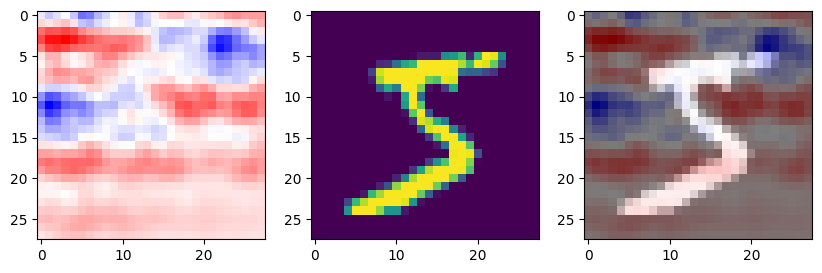

In [433]:
model = mnist2
sp = reshape_tile
x, y = trainset[0]

model.eval()
print('predicted:', model(sp(x[None].to(device))).argmax().item())
grads = model.saliency(x[None].to(device), t.tensor([y]).to(device), reshape=sp)

kernel = t.tensor([[[[0.07511361, 0.1238414 , 0.07511361],
 [0.1238414 , 0.20417996, 0.1238414 ],
 [0.07511361, 0.1238414 , 0.07511361]]]]).float().to(device)
print(x.shape)
grads = F.conv2d(grads, kernel, padding=1)

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(grads[0, 0].cpu().detach(), cmap='bwr')
axs[1].imshow(x[0])
axs[2].imshow(x[0], cmap='gray')
axs[2].imshow(grads[0, 0].cpu().detach(), cmap='bwr', alpha=0.5)

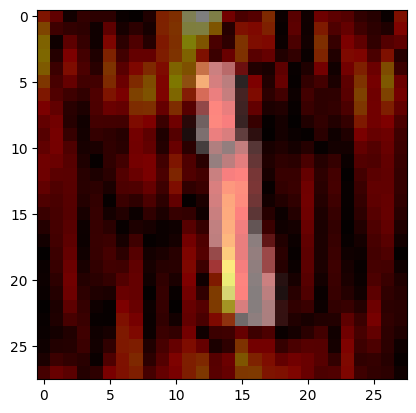

In [401]:
from PIL import Image
from captum.attr import Saliency

model = mnist
model.eval()

x, y = trainset[6]
input_tensor = x.to(device)
output = model(input_tensor)

saliency = Saliency(model)
input_tensor.requires_grad = True
output = model(input_tensor)
target = y
# target = output.argmax(dim=1)
saliency_map = saliency.attribute(input_tensor, target=target, abs=True)

saliency_map = saliency_map.squeeze().cpu().numpy()
# plt.imshow(saliency_map, cmap='hot')
# plt.colorbar()
# plt.title("Saliency Map")
# plt.show()


plt.imshow(x.squeeze(), cmap='gray')
plt.imshow(saliency_map, cmap='hot', alpha=0.5) 

In [428]:
# world = t.tensor([
#     [0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 1, 0, 0, 0, 0],
#     [0, 0, 0, 1, 0, 1, 0, 0],
#     [0, 0, 0, 1, 1, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0]], dtype=t.float32)

kernel = t.ones(1, 1, 3, 3).to(device)

kernel = t.tensor([[[[0.07511361, 0.1238414 , 0.07511361],
 [0.1238414 , 0.20417996, 0.1238414 ],
 [0.07511361, 0.1238414 , 0.07511361]]]]).float().to(device)

print(kernel.shape)
F.conv2d(grads, kernel, padding=1)[0, 0]

torch.Size([1, 1, 3, 3])


tensor([[ 2.3228e-03,  3.0408e-03,  3.2084e-03,  3.2603e-03,  2.7579e-03,
          1.8523e-03,  1.7378e-03,  1.9570e-03,  1.7862e-03,  1.6650e-03,
          1.6996e-03,  1.3605e-03,  5.8804e-04,  5.5637e-04,  8.1857e-04,
          7.2696e-04,  6.3530e-04,  8.0913e-04,  7.0852e-04,  1.4229e-04,
          5.8662e-05,  2.4998e-04,  3.0551e-04,  3.3322e-04,  5.8939e-04,
          6.7124e-04,  4.2293e-04,  1.6747e-04],
        [ 3.1229e-03,  3.9886e-03,  4.0617e-03,  4.3207e-03,  3.7586e-03,
          2.5537e-03,  2.5047e-03,  3.0105e-03,  2.7099e-03,  2.4946e-03,
          2.7864e-03,  2.4846e-03,  1.3453e-03,  1.1390e-03,  1.4735e-03,
          1.2749e-03,  1.0947e-03,  1.4828e-03,  1.4998e-03,  6.7600e-04,
          3.9010e-04,  5.2280e-04,  4.0112e-04,  2.9443e-04,  7.3670e-04,
          1.0326e-03,  7.1947e-04,  2.8832e-04],
        [ 2.9148e-03,  3.5844e-03,  3.1806e-03,  3.2457e-03,  3.0725e-03,
          2.0798e-03,  2.1109e-03,  2.9581e-03,  2.8384e-03,  2.3572e-03,
          2.60

### baseline

In [450]:
m2 = nn.Sequential(nn.Linear(28**2, d_hidden), nn.ReLU(), nn.Dropout(0.2), nn.Linear(d_hidden, 10)).to(device)
train_mnist(m2, trainloader, filename='mnist', epochs=40, reshape=nn.Flatten())

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▅▇█
loss,█▄▂▁
accuracy,0.8721
loss,0.59667


  0%|          | 0/40 [00:00<?, ?it/s]

loss=1.5537 accuracy=0.7587999701499939


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9542
loss,0.18618


predicted: 5
predicted: 5
predicted: 5
predicted: 5
predicted: 5
predicted: 5
predicted: 5
predicted: 5
predicted: 5
predicted: 5
predicted: 0
predicted: 0
predicted: 0
predicted: 0
predicted: 0
predicted: 0
predicted: 0
predicted: 0
predicted: 0
predicted: 0
predicted: 4
predicted: 4
predicted: 4
predicted: 4
predicted: 4
predicted: 4
predicted: 4
predicted: 4
predicted: 4
predicted: 4
predicted: 1
predicted: 1
predicted: 1
predicted: 1
predicted: 1
predicted: 1
predicted: 1
predicted: 1
predicted: 1
predicted: 1
predicted: 9
predicted: 9
predicted: 9
predicted: 9
predicted: 9
predicted: 9
predicted: 9
predicted: 9
predicted: 9
predicted: 9
predicted: 2
predicted: 2
predicted: 2
predicted: 2
predicted: 2
predicted: 2
predicted: 2
predicted: 2
predicted: 2
predicted: 2
predicted: 1
predicted: 1
predicted: 1
predicted: 1
predicted: 1
predicted: 1
predicted: 1
predicted: 1
predicted: 1
predicted: 1
predicted: 3
predicted: 3
predicted: 3
predicted: 3
predicted: 3
predicted: 3
predicted: 3

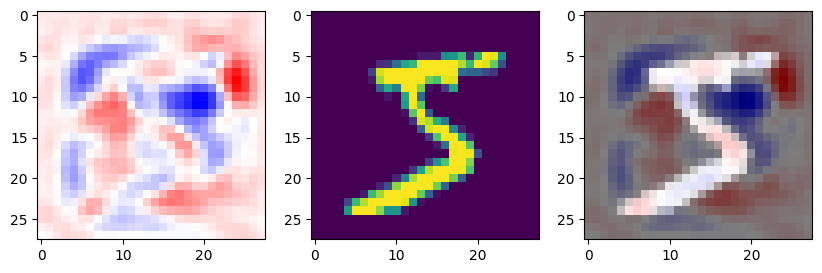

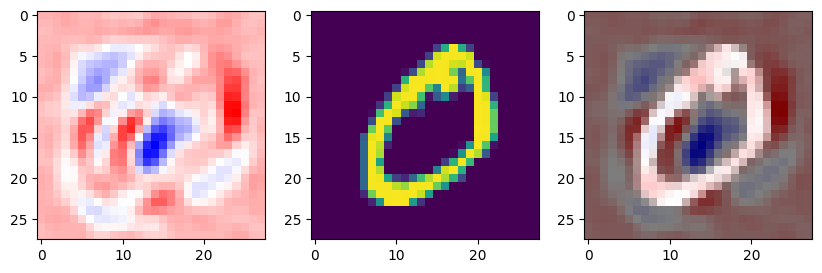

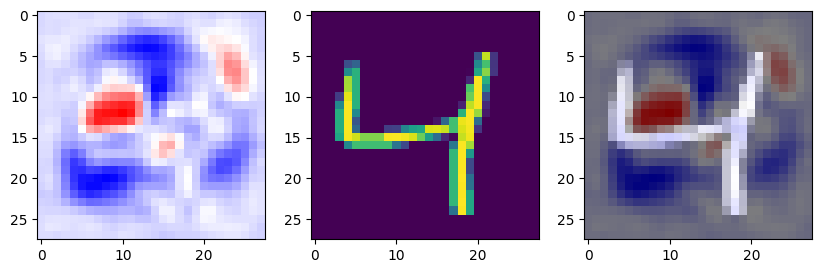

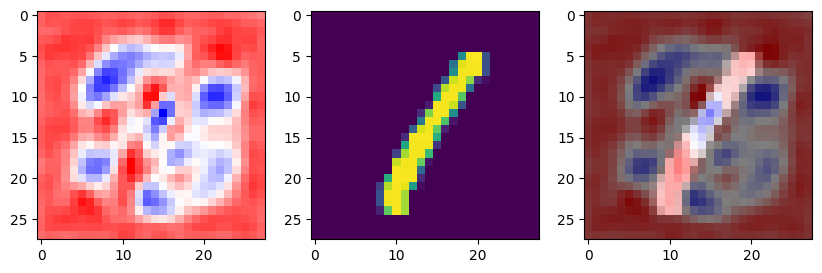

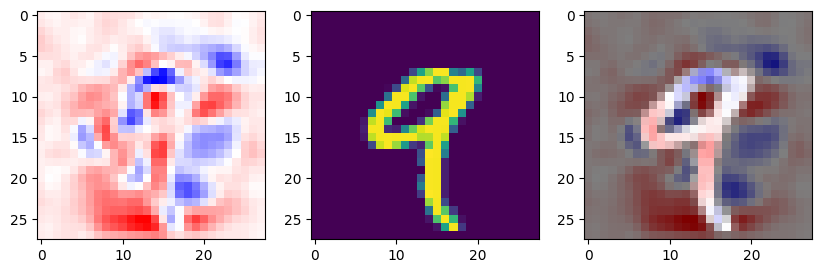

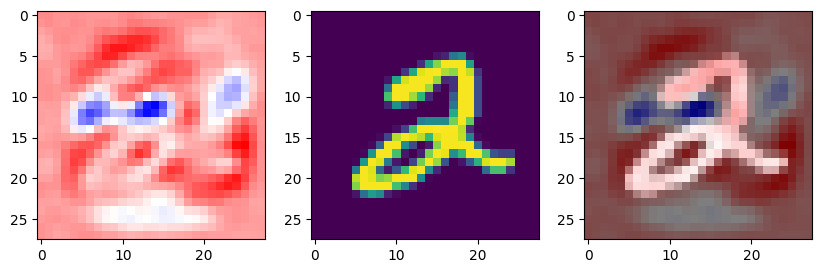

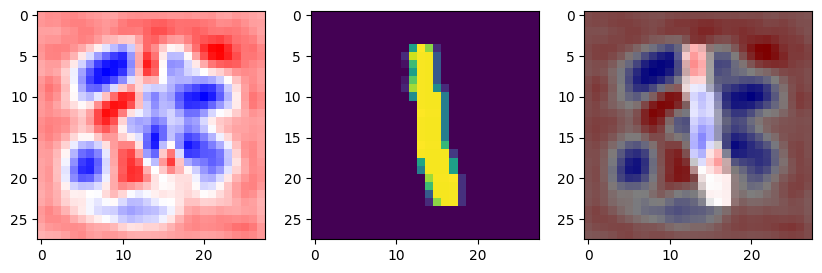

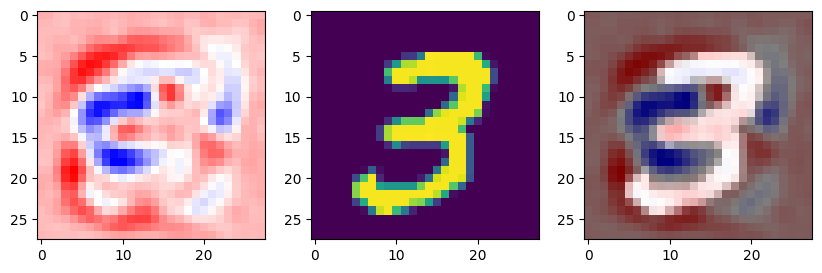

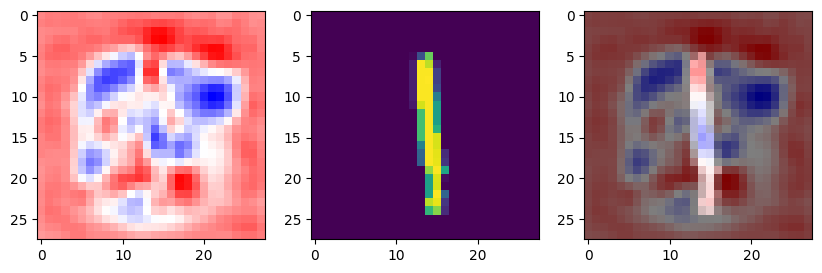

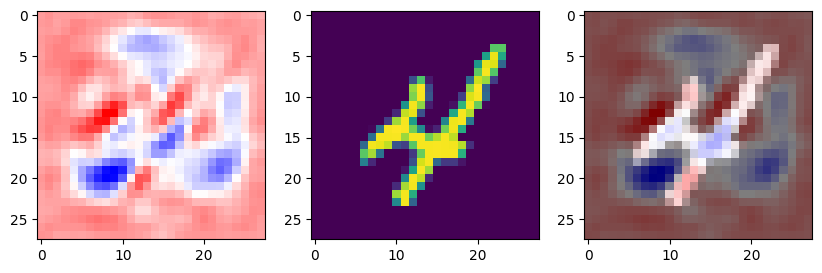

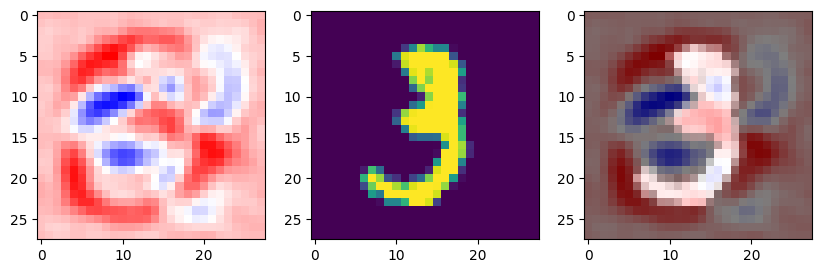

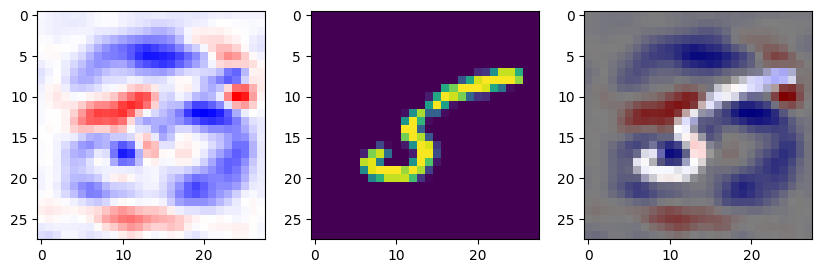

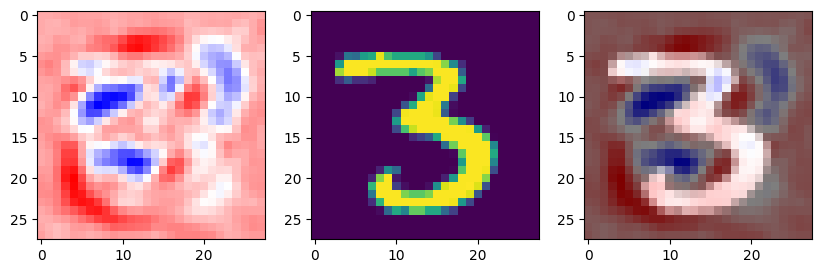

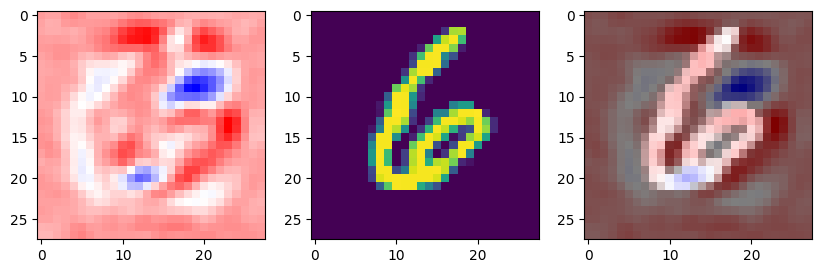

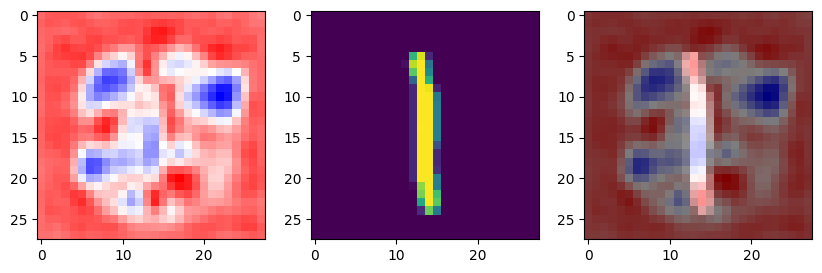

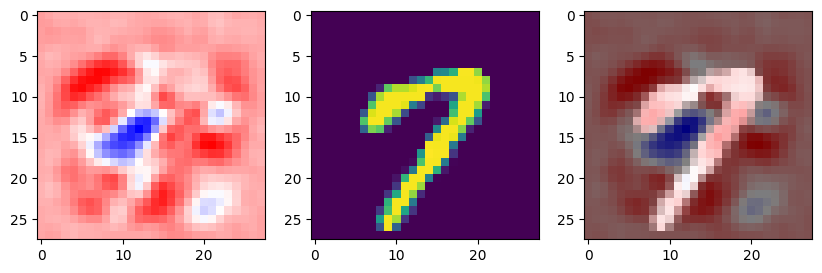

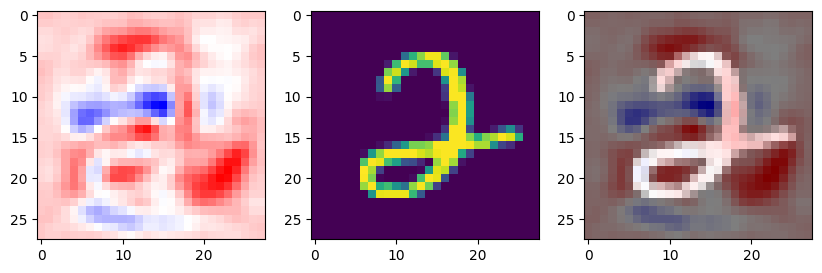

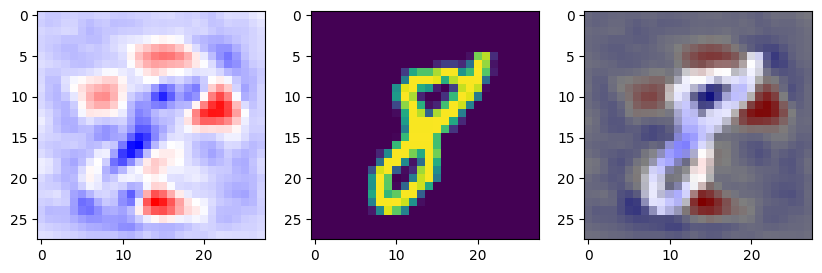

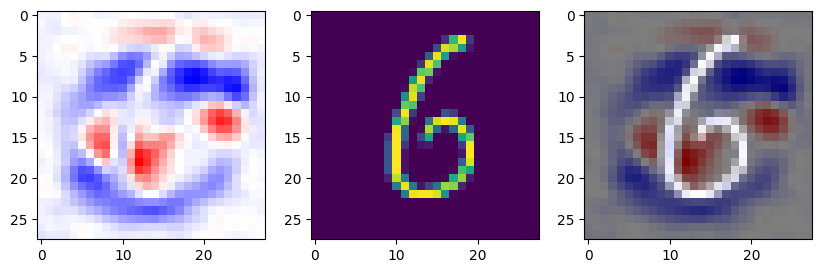

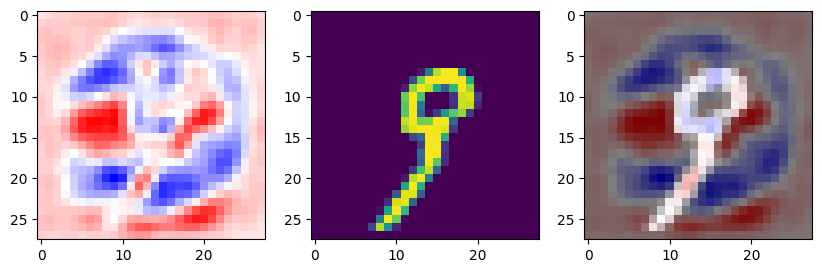

In [488]:
model = m2
sp = nn.Flatten()

for n in range(20):
    x, y = trainset[n]

    model.eval()
    x = x.to(device)
    x.requires_grad = True
    x.grad = None
    for _ in range(10):
        noise = t.randn_like(x) * 0.1
        out = model(sp(x + noise))
        print('predicted:', out.argmax().item())
        loss = F.cross_entropy(out, t.tensor([y]).to(device))
        loss.backward()
    grads = x.grad * x
    grads.abs()
    kernel = t.tensor([[[[0.07511361, 0.1238414 , 0.07511361],
    [0.1238414 , 0.20417996, 0.1238414 ],
    [0.07511361, 0.1238414 , 0.07511361]]]]).float().to(device)
    grads = F.conv2d(grads, kernel, padding=1)

    grads = grads[0].cpu().detach()
    x = x[0].cpu().detach()

    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(grads, cmap='bwr')
    axs[1].imshow(x)
    axs[2].imshow(x, cmap='gray')
    axs[2].imshow(grads, cmap='bwr', alpha=0.5)
